# To Do:
1. Load in MTurk data (.mat file)
1. Process into pandas data structure
1. Clean data (eliminate subjects with close to chance performance)
1. Compute general statistics on errors (mean, circstd, circkurtosis) on subjects by condition
1. Compute general statistics with bootstrapping to control for set size effects 
 * Compute differences between stay & switch trials within subject
1. Fit mixture model to group level data
1. Fit ANOVA to RT/std/K data w/ cue validity and swap as independent variables




In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Import packages
import scipy.io as sio
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

## Importing Data
First we will define the path to where our data is located. We will then use the scipy.io package to load 
the data and convert the format into a pandas DataFrame. DataFrames are a bit like arrays with discriptive names for columns. Values withing them can be indexed both by location and by name.

In [4]:
# data_root = '/Users/tim/Dropbox/mat_code/Behavioral/serences/data/UMI_MTurk/data/UMI_TASK_v5_pC/events'
data_root = '/home/AD/tsheehan/data/UMI_MTurk/UMI_v3/events'
data_loc = data_root + '/events.mat' #- this data is coming from a matlab format array of structures

In [181]:
raw_dat = sio.loadmat(data_loc)
ev_og = raw_dat['events'][0]
ev = ev_og.copy()
evF_og = pd.DataFrame(ev) 
evF_og.head()

,subject,prob,orients,cueLeft,lie,isPractice,correctAngle,correctAngleRad,startedAngle,reportedAngle,rt
0,[_5b1030fa70747],[[0.8]],"[[1, 56]]",[[1]],[[1]],[[1]],[[1]],[[0.017453292519943295]],[[281]],[[299]],[[968]]
1,[_5b1030fa70747],[[0.8]],"[[12, 92]]",[[1]],[[1]],[[1]],[[12]],[[0.20943951023931953]],[[355]],[[21]],[[591]]
2,[_5b1030fa70747],[[0.8]],"[[75, 72]]",[[1]],[[0]],[[1]],[[75]],[[1.3089969389957472]],[[297]],[[251]],[[727]]
3,[_5b1030fa70747],[[0.8]],"[[62, 153]]",[[0]],[[0]],[[1]],[[153]],[[2.670353755551324]],[[326]],[[325]],[[898]]
4,[_5b1030fa70747],[[0.8]],"[[70, 108]]",[[0]],[[1]],[[1]],[[108]],[[1.8849555921538759]],[[330]],[[331]],[[502]]


## Cleaning Data
We can quickly view the first few rows of data by using the "head" command (there is also a "tail" command to view the last few rows). The data we want is there... but it is formatted a bit funny. Instead of the DataFrame being populated with values (like floats or integers), it is filled with lists of lists (because of unknown reasons relating to how it imports the file). Instead of always having to deal with this funny formatting, we can right a quick function to make a DataFrame with just the values

In [106]:
def get_var(EV,VAR):
    if VAR == 'prob':
        foo = EV[VAR]
        out = np.array([float(foo[i]) for i in range(len(foo))])
    else:
        out = np.concatenate(EV[VAR])
    if len(EV[VAR][0][0])==2: #orients
        return out 
    if np.shape(out[0]):
        out = np.concatenate(out)
    if np.shape(out[0]): #- strings need to be concatenated an extra time
        out = np.concatenate(out)
    return out

def cleanDataFrame(ev,fieldsWant = ['subject','sess_num','lie']):
    print('Adding Fields:\n')
    df = pd.DataFrame() # columns=fieldsWant
    for fld in fieldsWant:
        if fld == 'orients':
            ori = get_var(ev,fld)
            L = [ori[i,0] for i in range(len(ori))]
            R = [ori[i,1] for i in range(len(ori))]
            df['TargL'] = L
            df['TargR'] = R
            print('TargL')
            print('TargR')
        else:
            df[fld] = get_var(ev,fld)
            print(fld) #- nice to reference
    return df

In [107]:
good_fields = ['subject','prob','cueLeft','lie','correctAngle',
             'reportedAngle','rt','orients']
evF = cleanDataFrame(ev,good_fields)
evF.head() 

Adding Fields:

subject
prob
cueLeft
lie
correctAngle
reportedAngle
rt
TargL
TargR


,subject,prob,cueLeft,lie,correctAngle,reportedAngle,rt,TargL,TargR
0,_5b1030fa70747,0.8,1,1,1,299,968,1,56
1,_5b1030fa70747,0.8,1,1,12,21,591,12,92
2,_5b1030fa70747,0.8,1,0,75,251,727,75,72
3,_5b1030fa70747,0.8,0,0,153,325,898,62,153
4,_5b1030fa70747,0.8,0,1,108,331,502,70,108


## Acessing Values in a dataFrame
Columns can be accessed by dot '.' or backet '[]' notation. Rows and columns can both be accessed by index/number as well. You will notice that each row has a counter assigned to it. This doesn't matter for now but will matter once we get subselect values from the dataFrame. To get just the values we can use the '.values()' command. Lastly, if we grab a slice of a dataFrame, just like with lists and arrays if we change the slice it will change the original dataFrame. To avoid this, we can use the '.copy()' command.

In [189]:
print(evF[5:15].correctAngle.values)
evF[5:15].correctAngle

[ 57  71 167  35  74 167 136 179  32  77]


5      57
6      71
7     167
8      35
9      74
10    167
11    136
12    179
13     32
14     77
Name: correctAngle, dtype: uint8

In [198]:
# order doesn't matter
print(evF[5:10]['rt'])
print(evF[5:10].rt)
print(evF['rt'][5:10])
print(evF.rt[5:10])

5    1301
6    1064
7     788
8    1239
9    1249
Name: rt, dtype: int32
5    1301
6    1064
7     788
8    1239
9    1249
Name: rt, dtype: int32
5    1301
6    1064
7     788
8    1239
9    1249
Name: rt, dtype: int32
5    1301
6    1064
7     788
8    1239
9    1249
Name: rt, dtype: int32


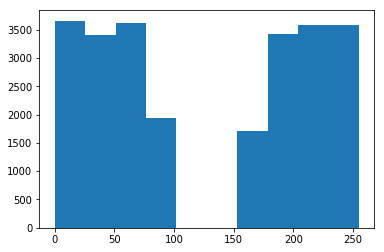

Data type: <class 'numpy.uint8'>


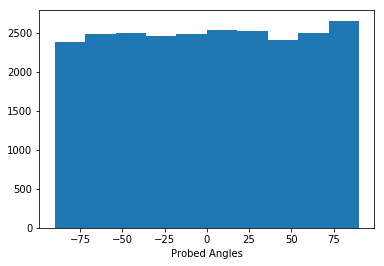

In [216]:
probed_angles = evF.correctAngle.values.copy()
probed_angles_centered = probed_angles-90
plt.hist(probed_angles_centered)
plt.show()
print('Data type: %s' %type(probed_angles[0])) # be carefull of datatypes! unsigned integers can't be negative.

probed_angles = evF.correctAngle.values.copy().astype(int)
probed_angles_centered = probed_angles-90
plt.hist(probed_angles_centered)
plt.xlabel('Probed Angles')
plt.show()

## Adding fields to a dataFrame
Now we have a much cleaner data set to work with. We want to add a few additional fields to indicate the angle that wasn't probed. We also want to make sure all reponse angles are in the range [0, 180]. We will also keep the add a field for response error (E) and add a modified RT field that keeps values <8000 ms.

In [118]:
wrongAngle = evF.correctAngle.values.copy() # determine non-target angle
wrongAngle[evF.cueLeft.values==1] = evF.TargR[evF.cueLeft.values==1]
wrongAngle[evF.cueLeft.values==0] = evF.TargL[evF.cueLeft.values==0]
evF['wrongAngle'] = wrongAngle

evF.reportedAngle[evF.reportedAngle.values>180] = evF.reportedAngle[evF.reportedAngle.values>180]-180

E = evF.correctAngle.values.astype(int).copy() - evF.reportedAngle.values.copy() 
E[np.abs(E)>90] = E[np.abs(E)>90] - np.sign(E[np.abs(E)>90])*180
evF['E'] = E

# itemProb = evF.prob.values.astype(float).copy()*100
# itemProb[evF.lie == True] = 100 - itemProb[evF.lie == True]
# itemProb[(itemProb==50) & (evF.lie == True)] = 49
# itemProb[(itemProb==50) & (evF.lie == False)] = 51
# evF['itemProb'] = itemProb

# reduce unreasonable response times to managable values for visualization
rt = evF.rt.values.copy()
m_rt = 8000
rt[rt>m_rt] = m_rt
evF['RTc'] = rt

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [115]:
# helper functions
from scipy.stats import circstd
def circ_std(x): return circstd(x,90,-90)
def ismember(a,b):
    status = []
    for aa in a:
        for bb in b:
            if aa==bb:
                status.append(True)
                break  
        else: status.append(False)
    return status

## Quickly visualize the error and response time distribution using the distplot function from the seaborn package:

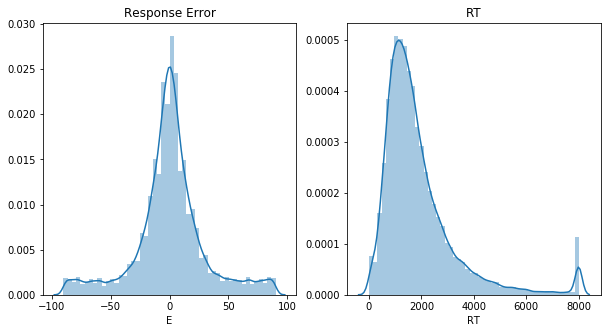

In [116]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(evF.E)
plt.title('Response Error')

plt.subplot(1,2,2)
sns.distplot(rt)
plt.xlabel('RT')
plt.title('RT')
plt.show()

## Remove participants with near chance performance before completing further analysis
This data was collected from Amazon's Mechanical Turk in which willing participants complete tasks from their personal computers for a predetermined payment. Because this is not a controlled environment, data quality can be an issue. As a quick and dirty way to clean the data, we will use list comprehension to get the circular standard deviation of errors for each participant and eliminate those with near chance performance.

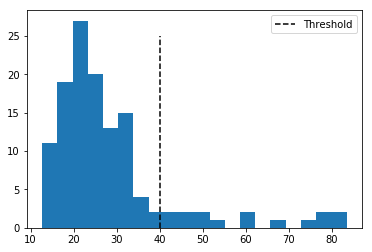

In [217]:
max_err = 40
subjs = np.unique(evF.subject)
# sub_err = np.array([np.mean(np.abs(evF[evF.subject==s].E)) for s in subjs])
sub_err = np.array([circ_std(evF[evF.subject==s].E) for s in subjs]) # List Comprehension
bad_sub = subjs[sub_err>max_err]
bad_ind = np.array(ismember(evF.subject,bad_sub))
evF_use = evF[~bad_ind]

plt.hist(sub_err,20)
plt.plot([max_err,max_err],[0,25],'k--')
plt.legend(('Threshold',))
plt.show()

## Data Visualization
Now that we have "cleaned" the data, we can see look at some of the effects we are interested in. Principally how cue validity effects response variability. We will create a DataFrame to store the outputs of this analysis. For now we will compute the circular standard deviation of errors and response times given the cue validity and its probability of being valid. We will then visualize the output using the seaborn package.

First we will initialize a dataFrame S which we will append to. Pandas "Series" objects are a lot like dictionaries and can easily be added to dataFrames.

In [126]:
# summary by subject
S = pd.DataFrame()
for sub in np.unique(evF_use.subject):
    for l in (0,1,2):
        if (l==2):
            dat_use = evF_use[evF_use.subject==sub]
        else:
            dat_use = evF_use[(evF_use.subject==sub)&(evF_use.lie==l)]
        S_ = pd.Series({'subject':sub,'lie':l,'sd':circ_std(dat_use.E),'rt':np.median(dat_use.rt),
                       'prob':dat_use.prob.values[0]}) # Series objects behave like dictionaries and can easily be appended to DataFrames 
        S = S.append(S_,ignore_index=True)            

Once we have our dataFrame from our analysis we can quickly visualize it in a number of ways using the seaborn package. Lets see if response time is effected by our task condition. We can easily overlay different types of plots, in this case a box plot and a swarmplot. Other basic types of plots for 2 variables include **{violin, point, boxen, line, and reg}**

Text(0,0.5,'Response Time')

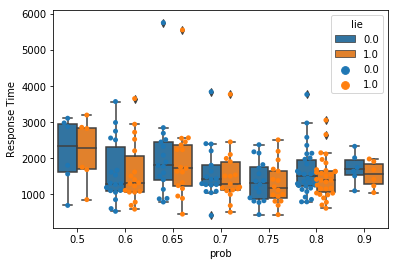

In [221]:
sns.boxplot(x='prob',y='rt',hue='lie',data=S[S.lie!=2])
sns.swarmplot(x='prob',y='rt',hue='lie',data=S[S.lie!=2],dodge=True)
plt.ylabel('Response Time')

Response Times seem to be relatively unaffected by our task conditions. What we are really interested in is the error distributions. For a clean visualization we will use pointplot which automatically computes 95% confidence intervals for each condition. Pretty useful if you want to get a sense of it two groups are meaningfully different.

Text(0.5,1,'Error Variance vs. Cue Validity')

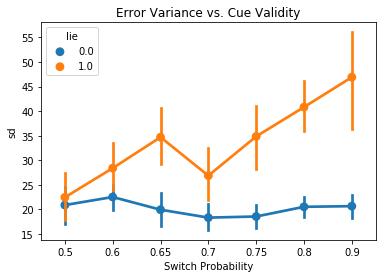

In [125]:
sns.pointplot(x='prob',y='sd',hue='lie',data=S[S.lie!=2])
plt.xlabel('Switch Probability')
plt.title('Error Variance vs. Cue Validity')

## Bootstrap Analysis
Clearly the error distribution increases on switch trials with cue validity. It's not clear if this is being mediated by low trial counts in this condition though (the groups with the greatest standard deviation also have the smallest number of trials). To account for this, we can keep the trial counts the same across conditions using bootstrapping.

In [139]:
def quick_boot(x,fun,n_samp_per_boot,n_iterations=30):
    y = []
    for i in range(n_iterations):
        ii = round(np.random.sample(n_samp_per_boot)*len(y))
        xi = x[ii]
        y.append(fun(xi))
    return y

In [143]:
# summary by subject
n_samp_per_boot = 30 #- nTrials per bootstrap

Sb = pd.DataFrame()
for sub in np.unique(evF_use.subject):
    if (sum((evF_use.subject==sub)&(evF_use.lie==1))<n_boot):
        print('Skipping %s, not enough switch trials' %(sub,))
    for l in (0,1,2):
        if (l==2):
            dat_use = evF_use[evF_use.subject==sub]
        else:
            dat_use = evF_use[(evF_use.subject==sub)&(evF_use.lie==l)]
        S_ = pd.Series({'subject':sub,'lie':l,'rt':np.median(dat_use.rt),
                       'prob':dat_use.prob.values[0]}) # Series objects behave like dictionaries and can easily be appended to DataFrames 
        sd = my_boot(dat_use.E.values,circ_std,n_samp_per_boot)
        S_['sd'] = np.mean(sd)
        Sb = Sb.append(S_,ignore_index=True)            

Skipping _5b1030fa70747, not enough switch trials
Skipping _5b1072d0cbb17, not enough switch trials
Skipping _5b119961e8e3d, not enough switch trials
Skipping _5b1199e3cc51b, not enough switch trials
Skipping _5b119a0a0d188, not enough switch trials
Skipping _5b119c01be4fc, not enough switch trials
Skipping _5b11a99c91560, not enough switch trials
Skipping null, not enough switch trials


Text(0.5,1,'Error Variance vs. Cue Validity')

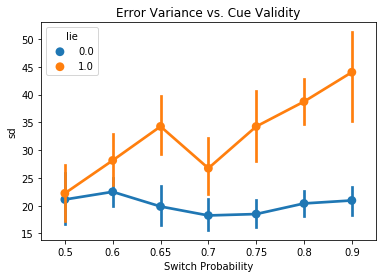

In [144]:
sns.pointplot(x='prob',y='sd',hue='lie',data=Sb[Sb.lie!=2])
plt.xlabel('Switch Probability')
plt.title('Error Variance vs. Cue Validity')

It looks like the effects of cue validity are indeed due to behavioral differences and not an artifact of trial counts. What if we looked at differences within subjects

In [166]:
Sd = pd.DataFrame()
for sub in np.unique(Sb.subject):
    S_ = pd.Series({'d_sd':Sb[(Sb.subject==sub)&(Sb.lie==0)].sd.values[0]-Sb[(Sb.subject==sub)&(Sb.lie==1)].sd.values[0],
                    'prob':Sb[(Sb.subject==sub)&(Sb.lie==2)].prob.values[0]})
    Sd = Sd.append(S_,ignore_index=True)

Text(0.5,0,'Cue Validity')

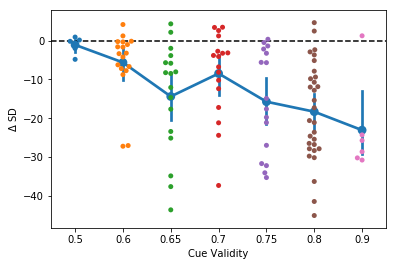

In [229]:
sns.pointplot(x='prob',y='d_sd',data=Sd)
sns.swarmplot(x='prob',y='d_sd',data=Sd,dodge=1)
plt.plot([-.5, 6.5],[0,0],'k--') # add a line to represent our null hypothesis (no difference between stay and switch conditions)
plt.ylabel('$\Delta$ SD')
plt.xlabel('Cue Validity')

## Probably Stop about here... rest will be deleted or cleaned up
But could also include model fitting to show off catplot/pairplot

In [14]:
probs = np.unique(evF.itemProb)
S = pd.DataFrame(columns={'validity','prob','lie','K','PG','PNT','sd','RT','LL'})
for p in probs:
    this_dat = evF_use[evF_use.itemProb==p]
    
    S_ = pd.Series({'validity':p,'RT':np.mean(this_dat.rt),'sd':circ_std(this_dat.E)})
    out,_ = wrap_full_mixture(this_dat.correctAngle.astype(float),this_dat.wrongAngle.astype(float),this_dat.reportedAngle.astype(float))
    S_['K'],S_['PG'],S_['PNT'] = out.x
    S_['LL'] = out.fun
    S_['prob'],S_['lie'] = (this_dat.prob.values[0],this_dat.lie.values[0])
    S = S.append(S_,ignore_index=True)
    print(p)


/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


10.0
20.0
25.0
30.0
35.0
40.0
49.0
51.0
60.0
65.0
70.0
75.0
80.0
90.0


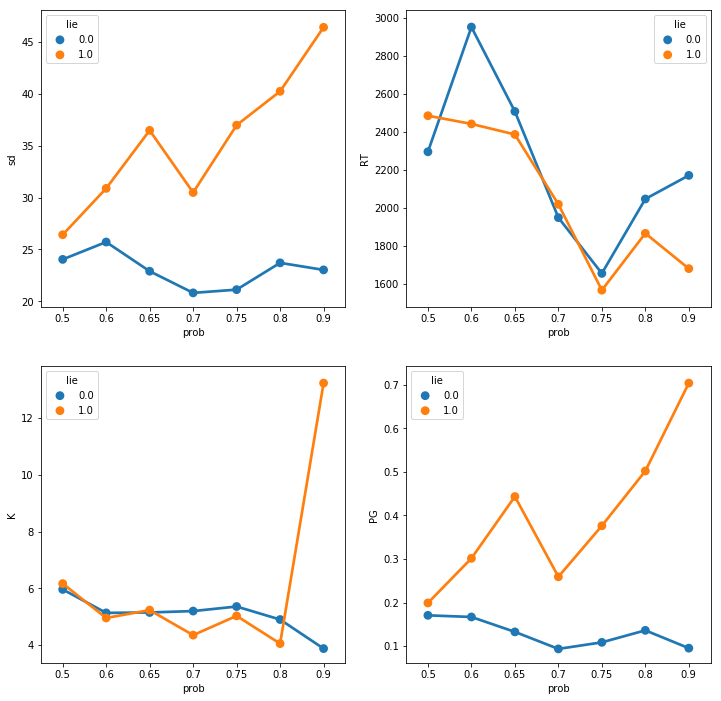

In [15]:
# sns.pointplot(x='validity',y='PG',data=S)
# sns.distplot(this_dat.E)
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.pointplot(x='prob',y='sd',hue='lie',data=S)

plt.subplot(2,2,2)
sns.pointplot(x='prob',y='RT',hue='lie',data=S)

plt.subplot(2,2,3)
sns.pointplot(x='prob',y='K',hue='lie',data=S)

plt.subplot(2,2,4)
sns.pointplot(x='prob',y='PG',hue='lie',data=S)

In [87]:
T = this_dat.correctAngle.astype(float)
R = this_dat.reportedAngle.astype(float)
NT = this_dat.wrongAngle.astype(float)
E_T  = deg2rad(wrap_E(T-R))*2
E_NT = deg2rad(wrap_E(NT-R))*2
C0 = np.array([12,.1,.1,2]) #- starting coeff K,Pg, Pnt
def full_mixture(C): 
    return -np.sum(np.log((1-C[1]-C[2])*vonmises.pdf(E_T,C[0])+C[1]/(2*np.pi)+C[2]*vonmises.pdf(E_NT,C[3])))

out_all = []
for k_start in np.linspace(0.5,5,10):
    C0[0] = k_start
    for pg in np.linspace(0,.5,5):
        C0[1] = pg
        out_all.append(minimize(full_mixture,C0, method='SLSQP',bounds=((0,30),(0,1),(0,1),(0,30)))) # ,method='Nelder-Mead'


/home/AD/tsheehan/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


In [271]:
foo = minimize(full_mixture,C0, method='SLSQP',bounds=((0,30),(0,1),(0,1),(0,30)))


In [ ]:
# do diff sd, avg sd for each subject to directly compare lie and non-lie w-in subject


In [22]:
# fit for individual subjects (use all)
# record: avg error, LL, K, PG, PNT, RT, emp & listed prob
Si = pd.DataFrame(columns={'subject','validity','prob','lie','K','PG','PNT','sd','sd_o','RT','LL'})
mRT = 8000
for sub in subjs:
    sd_o = circ_std(evF[(evF.subject==sub)].E)
    for l in (0,1):
        this_dat = evF[(evF.subject==sub) & (evF.lie==l)]

        S_ = pd.Series({'subject':sub,'validity':p,'RT':np.median(this_dat.RTc),'sd':circ_std(this_dat.E),'sd_o':sd_o})
        out,_ = wrap_full_mixture(this_dat.correctAngle.astype(float),this_dat.wrongAngle.astype(float),this_dat.reportedAngle.astype(float))
        S_['K'],S_['PG'],S_['PNT'] = out.x
        S_['LL'] = out.fun
        S_['prob'],S_['lie'] = (this_dat.prob.values[0],this_dat.lie.values[0])
        Si = Si.append(S_,ignore_index=True)
    print(sub)

/home/AD/tsheehan/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


_5b1030fa70747
_5b1039b0c7cb5
_5b103ae28108a
_5b103de3d5171
_5b1049432ce08
_5b107005ce935
_5b10706a1d71d
_5b1070a217407
_5b10720b6582b
_5b10723386433
_5b1072d0cbb17
_5b10732517984
_5b10733643830
_5b10734739f6a
_5b107420a7a15
_5b10764b2abbd
_5b107d9c53d4d
_5b1082ce07a73
_5b108304555aa
_5b1083ddd797d
_5b1084c705163
_5b108ac591f56
_5b108b2e1f4fb
_5b108f09644e9
_5b116405d0a32
_5b11648e65128
_5b116569ba8f1
_5b1165e1a00c4
_5b1166f64ba35
_5b11677da1b4d
_5b1167efdc31c
_5b116a41c3c41
_5b116a9127b6d
_5b116bca30665
_5b116d6a19efb
_5b116fa258535
_5b117a5c01c8d
_5b117cb199897
_5b117ccc85565
_5b117cf0d06c3
_5b117d043916a
_5b117d7769964
_5b117d87844eb
_5b117de3dc21a
_5b117ea30d9f7
_5b117ee816b8b
_5b1180d225c53
_5b11816337f28
_5b118168ecde3
_5b1181c1e988c
_5b1184355b6b4
_5b1184ce1d18d
_5b1189a978417
_5b118c62ee9a1
_5b1195e484658
_5b1196cfda1d6
_5b1196ea5140a
_5b1198734b1bd
_5b11988152471
_5b1198c168f8e
_5b119961e8e3d
_5b11998fc4a09
_5b1199e3cc51b
_5b119a0a0d188
_5b119abbe6c0e
_5b119c01be4fc
_5b119c94d

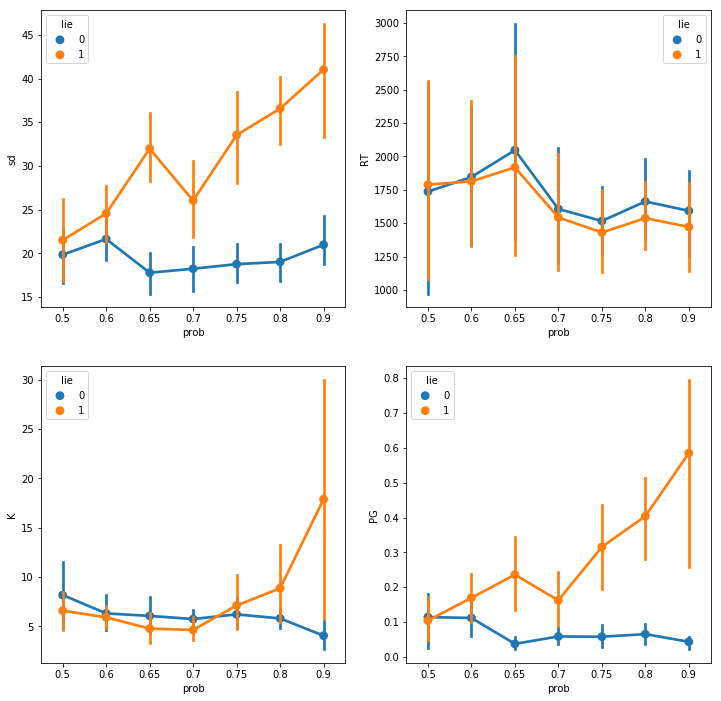

In [23]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.pointplot(x='prob',y='sd',hue='lie',data=Si[Si.sd_o<30])

plt.subplot(2,2,2)
sns.pointplot(x='prob',y='RT',hue='lie',data=Si[Si.sd_o<30])

plt.subplot(2,2,3)
sns.pointplot(x='prob',y='K',hue='lie',data=Si[Si.sd_o<30])

plt.subplot(2,2,4)
sns.pointplot(x='prob',y='PG',hue='lie',data=Si[Si.sd_o<30])


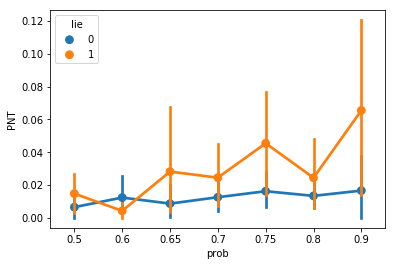

In [24]:
sns.pointplot(x='prob',y='PNT',hue='lie',data=Si[Si.sd_o<30])

In [63]:
import fit_MM_v1


In [125]:
import warnings
warnings.simplefilter("ignore")

this_dat = evF[(evF.subject==subjs[5])]
out = fit_MM_v1.fit_mixture_boot(this_dat.correctAngle.values.astype(float),this_dat.wrongAngle.values.astype(float),
                                 this_dat.reportedAngle.values.astype(float),sz_boot=40,n_boot=30,use_pool=True)



In [ ]:
# fit for individual subjects (use all)
# record: avg error, LL, K, PG, PNT, RT, emp & listed prob
if Sib:
    error() # preven overwrite
    
Sib = pd.DataFrame(columns={'subject','eprob','prob','lie','K','PG','PNT',
                            'sd','sd_o','RT','LL','sz_boot','n_boot','d_prime'})
dPrime_try=np.linspace(0.5,4.0,40)
mRT = 8000
sz_boot = 40
n_boot = 30
for sub in subjs:  # subject loop
    print('%s' %sub, end="", flush=True)
    sd_o = circ_std(evF[(evF.subject==sub)].E)
    eprob = np.mean(evF[evF.subject==sub].lie)
    
    if (sum((evF.subject==sub)&(evF.lie==1))<=sz_boot):
        print('  ...Skipping!')
        continue
        
    for l in (0,1,2): # looping over valids/invalids/all
        if (l==2):
            this_dat = evF[(evF.subject==sub)]
            sz_boot_use = 150 # can double because using valid + invalid trials
        else:
            this_dat = evF[(evF.subject==sub) & (evF.lie==l)]
            sz_boot_use = sz_boot
            
        S_ = pd.Series({'subject':sub,'RT':np.median(this_dat.RTc),'sd':circ_std(this_dat.E),
                        'sd_o':sd_o,'sz_boot':sz_boot_use,'eprob':eprob,'n_boot':n_boot})
        out,LL = fit_MM_v1.fit_mixture_boot(this_dat.correctAngle.values.astype(float),
                                            this_dat.wrongAngle.values.astype(float),
                                            this_dat.reportedAngle.values.astype(float),
                                            sz_boot=sz_boot_use,n_boot=n_boot,use_pool=True)

        S_['d_prime']=TCM_model_v3.compute_dPrime_r_boot(dPrime_try,this_dat.E.values,sz_boot,n_boot)
    
        S_['K'],S_['PG'],S_['PNT'] = out
        S_['LL'] = LL
        S_['prob'],S_['lie'] = (this_dat.prob.values[0],l)
        Sib = Sib.append(S_,ignore_index=True)
        print(' %d-%d' %(prob,l), end="", flush=True)
    print(' ...Done!')
    

_5b1030fa70747  ...Skipping!
_5b1039b0c7cb5  ...Skipping!
_5b103ae28108a  ...Skipping!
_5b103de3d5171 90-0 90-1 90-2 ...Done!
_5b1049432ce08  ...Skipping!
_5b107005ce935 90-0 90-1 90-2 ...Done!
_5b10706a1d71d  ...Skipping!
_5b1070a217407  ...Skipping!
_5b10720b6582b

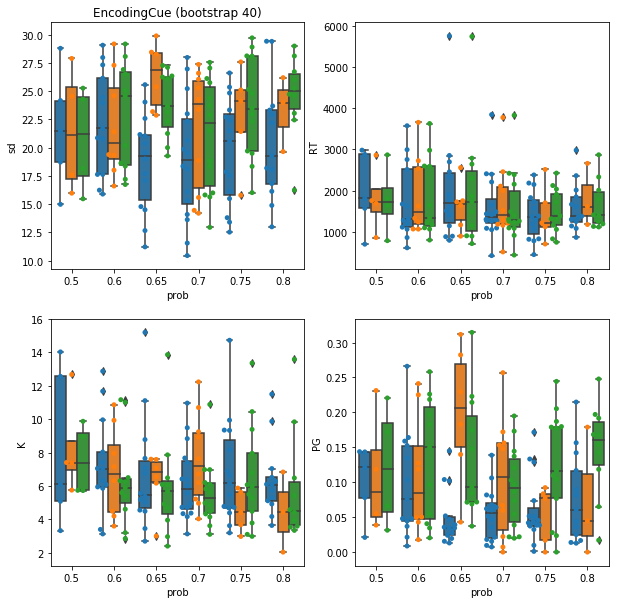

In [347]:
this_dat = Sib[(Sib.sd<30)&(Sib.lie<3)]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
var = 'sd'
ax = sns.boxplot(data=this_dat,x='prob',y=var,hue='lie')
ax = sns.swarmplot(data=this_dat,x='prob',y=var,hue='lie',dodge=True)
ax.legend_.remove()
plt.title('EncodingCue (bootstrap 40)')

plt.subplot(2,2,2)
var = 'RT'
ax = sns.boxplot(data=this_dat,x='prob',y=var,hue='lie')
ax = sns.swarmplot(data=this_dat,x='prob',y=var,hue='lie',dodge=True)
ax.legend_.remove()

plt.subplot(2,2,3)
var = 'K'
ax = sns.boxplot(data=this_dat,x='prob',y=var,hue='lie')
ax = sns.swarmplot(data=this_dat,x='prob',y=var,hue='lie',dodge=True)
ax.legend_.remove()

plt.subplot(2,2,4)
var = 'PG'
ax = sns.boxplot(data=this_dat,x='prob',y=var,hue='lie')
ax = sns.swarmplot(data=this_dat,x='prob',y=var,hue='lie',dodge=True)
ax.legend_.remove()


In [343]:
# import importlib
# importlib.reload(TCM_model_v3)

<module 'TCM_model_v3' from '/mnt/neurocube/home/tsheehan/py_code/UMI_analysis/TCM_model_v3.py'>

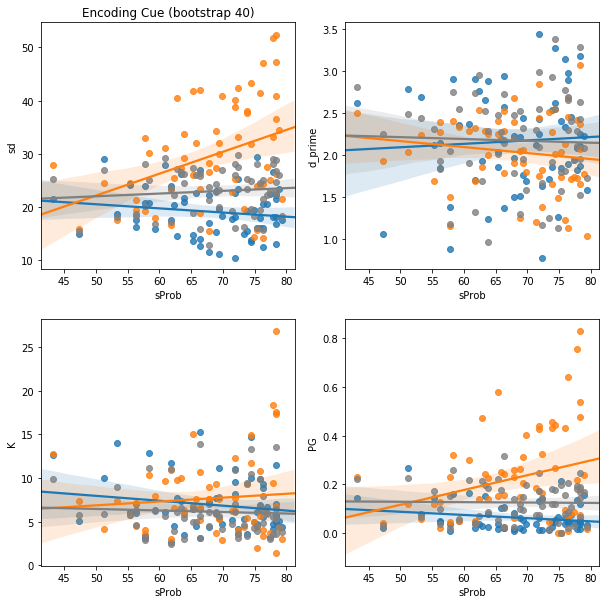

In [384]:
Sib['sProb'] = (1-Sib['eprob'])*100
use = Sib.sd_o<30

plt.figure(figsize=(10,10))
show_neutral = True

plt.subplot(2,2,1)
var_y = 'sd'
this_dat = Sib[use&(Sib.lie==0)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==1)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==2)]
if show_neutral: sns.regplot(data=this_dat,x='sProb',y=var_y,color='gray')
plt.title('Encoding Cue (bootstrap 40)')

plt.subplot(2,2,2)
var_y = 'd_prime'
this_dat = Sib[use&(Sib.lie==0)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==1)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==2)]
if show_neutral: sns.regplot(data=this_dat,x='sProb',y=var_y,color='gray')

plt.subplot(2,2,3)
var_y = 'K'
this_dat = Sib[use&(Sib.lie==0)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==1)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==2)]
if show_neutral: sns.regplot(data=this_dat,x='sProb',y=var_y,color='gray')

plt.subplot(2,2,4)
var_y = 'PG'
this_dat = Sib[use&(Sib.lie==0)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==1)]
sns.regplot(data=this_dat,x='sProb',y=var_y)
this_dat = Sib[use&(Sib.lie==2)]
if show_neutral: sns.regplot(data=this_dat,x='sProb',y=var_y,color='gray')



In [251]:
# Add TCM modeling?
import TCM_model_v3

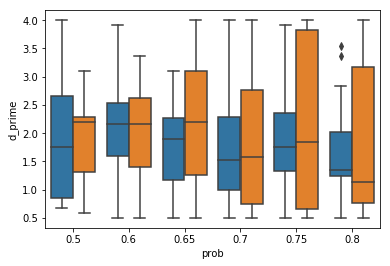

In [270]:
ax = sns.boxplot(data=Sib[Sib.lie<2],x='prob',y='d_prime',hue='lie')
ax.legend_.remove()

In [293]:
Sib_floats = Sib.copy()
Sib_floats.lie = Sib_floats.lie.astype(str)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Analysis of Variance Table

Response: PG
           Df Sum Sq Mean Sq F value   Pr(>F)    
sProb       1 0.0025 0.00247  0.0610  0.80516    
lie         1 1.0006 1.00055 24.7540 1.41e-06 ***
sProb:lie   1 0.1883 0.18826  4.6577  0.03212 *  
Residuals 198 8.0031 0.04042                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


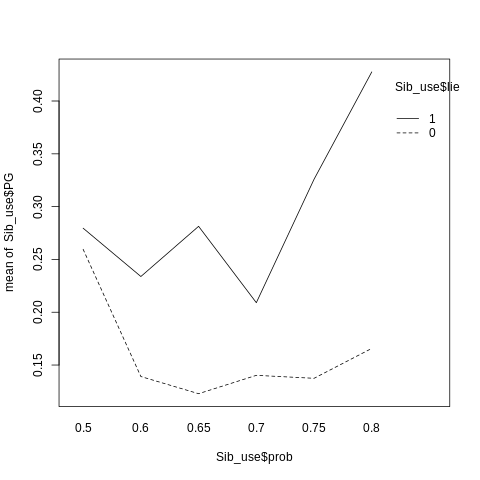

In [362]:
%%R -i Sib_floats
Sib_use <- Sib_floats[Sib_floats$lie<2,]
interaction.plot(Sib_use$prob,Sib_use$lie,Sib_use$PG)
mod = lm(PG~sProb*lie,data=Sib_use)
anova(mod)

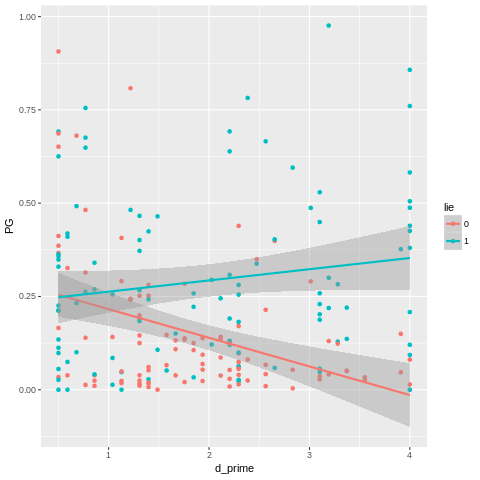

In [371]:
%%R
library(ggplot2)

# qplot(x=sProb,y=sd,color=lie,data=Sib_use) + geom_smooth(method='lm')
# qplot(x=K,y=sd,color=lie,data=Sib_use) + geom_smooth(method='lm')
# qplot(x=sProb,y=PG,color=lie,data=Sib_use) + geom_smooth(method='lm')

qplot(x=d_prime,y=PG,color=lie,data=Sib_use) + geom_smooth(method='lm')


Text(0.5,1,'Encoding Cue (bootstrap 40)')

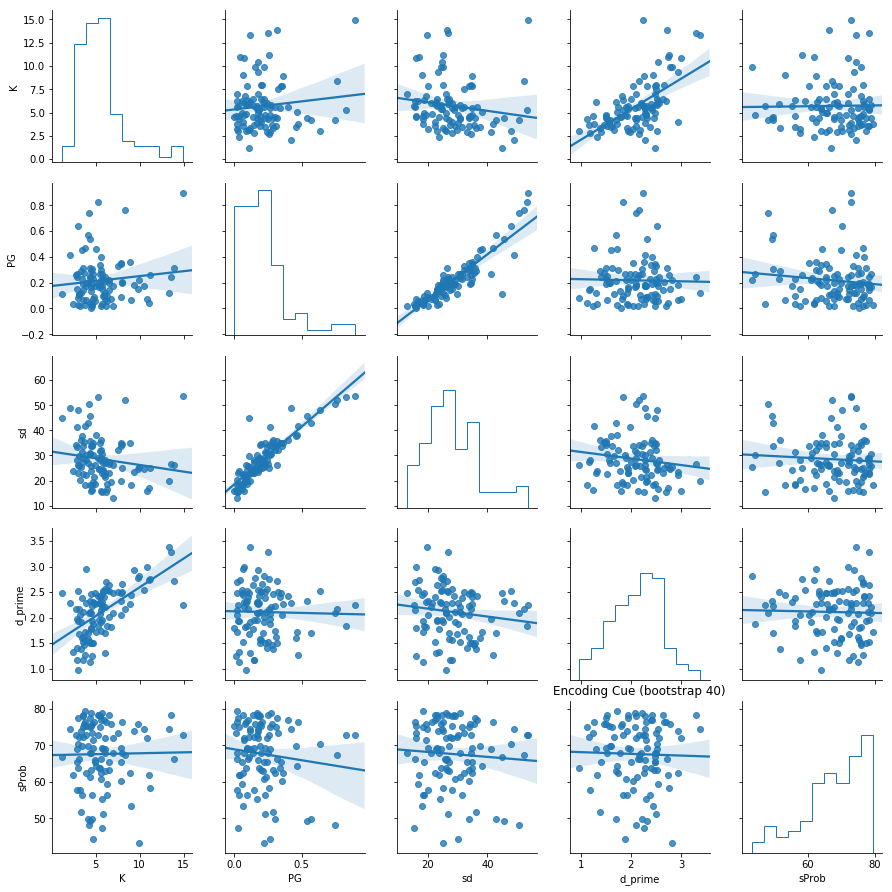

In [383]:
g = sns.PairGrid(Sib[Sib.lie==2],vars=['K','PG','sd','d_prime','sProb'],hue='lie') # ,'sProb'
g = g.map_diag(plt.hist, histtype="step")
g = g.map_upper(sns.regplot)
g = g.map_lower(sns.regplot)
plt.title('Encoding Cue (bootstrap 40)')

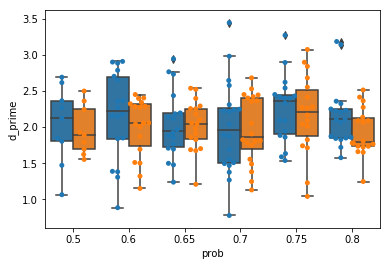

In [378]:
sns.boxplot(data=Sib[Sib.lie<2],x='prob',y='d_prime',hue='lie')
ax = sns.swarmplot(data=Sib[Sib.lie<2],x='prob',y='d_prime',hue='lie',dodge=1)
ax.legend_.remove()

In [594]:
# fit for individual subjects (use all)
# record: avg error, LL, K, PG, PNT, RT, emp & listed prob
if Sib2:
    error() # preven overwrite

import multiprocessing as mp

Sib2 = pd.DataFrame(columns={'subject','eprob','prob','lie','K','PG','PNT',
                            'sd','sd_o','RT','LL','sz_boot','n_boot','d_prime',
                            'K_','PG_','PNT_','sd_','LL_','d_prime_'})
dPrime_try=np.linspace(0.1,6.0,50)
mRT = 8000
sz_boot = 40
n_boot = 30
for sub in subjs:  # subject loop
    print('%s' %sub, end="", flush=True)
    sd_o = circ_std(evF[(evF.subject==sub)].E)
    eprob = np.mean(evF[evF.subject==sub].lie)
    
    if (sum((evF.subject==sub)&(evF.lie==1))<=sz_boot):
        print('  ...Skipping!')
        continue
        
    for l in (0,1,2): # looping over valids/invalids/all
        if (l==2):
            this_dat = evF[(evF.subject==sub)]
            sz_boot_use = 150 # can double because using valid + invalid trials
        else:
            this_dat = evF[(evF.subject==sub) & (evF.lie==l)]
            sz_boot_use = sz_boot
            
        S_ = pd.Series({'subject':sub,'RT':np.median(this_dat.RTc),'sd':circ_std(this_dat.E),
                        'sd_o':sd_o,'sz_boot':sz_boot_use,'eprob':eprob,'n_boot':n_boot})
        
        I = []
        for i in range(n_boot):
            ind = np.random.choice(len(this_dat),sz_boot_use,True) # with replacement
            I.append(ind)
            
        output = mp.Queue()
        processes = [mp.Process(target=fit_lap,args=(this_dat,ii,output)) for ii in I]
        for p in processes:
            p.start()
        for p in processes:
            p.join()
        results = [output.get() for p in processes]
        
        X,LL,d_prime,sd = ([],[],[],[])
        [X.append(r[0][0]) for r in results]
        [LL.append(r[0][1]) for r in results]
        [d_prime.append(r[1]) for r in results]
        [sd.append(r[2]) for r in results]
        X = np.stack(X)

        S_['K'],S_['PG'],S_['PNT'] = np.mean(X,0)
        S_['LL'] = np.mean(LL)
        S_['d_prime'] = np.mean(d_prime)
        
        S_['K_'],S_['PG_'],S_['PNT_'] = (X[:,0],X[:,1],X[:,2])
        S_['LL_'],S_['d_prime_'] = (LL,d_prime)
        S_['sd_'] = sd

        S_['prob'],S_['lie'] = (this_dat.prob.values[0],l)
        Sib2 = Sib2.append(S_,ignore_index=True)
        print(' %d-%d' %(prob,l), end="", flush=True)
    print(' ...Done!')
    

_5b1030fa70747  ...Skipping!
_5b1039b0c7cb5  ...Skipping!
_5b103ae28108a  ...Skipping!
_5b103de3d5171 90-0 90-1 90-2 ...Done!
_5b1049432ce08  ...Skipping!
_5b107005ce935 90-0 90-1 90-2 ...Done!
_5b10706a1d71d  ...Skipping!
_5b1070a217407  ...Skipping!
_5b10720b6582b 90-0 90-1 90-2 ...Done!
_5b10723386433 90-0 90-1 90-2 ...Done!
_5b1072d0cbb17  ...Skipping!
_5b10732517984 90-0 90-1 90-2 ...Done!
_5b10733643830 90-0 90-1 90-2 ...Done!
_5b10734739f6a 90-0 90-1 90-2 ...Done!
_5b107420a7a15 90-0 90-1 90-2 ...Done!
_5b10764b2abbd 90-0 90-1 90-2 ...Done!
_5b107d9c53d4d  ...Skipping!
_5b1082ce07a73  ...Skipping!
_5b108304555aa 90-0 90-1 90-2 ...Done!
_5b1083ddd797d  ...Skipping!
_5b1084c705163  ...Skipping!
_5b108ac591f56 90-0 90-1 90-2 ...Done!
_5b108b2e1f4fb  ...Skipping!
_5b108f09644e9 90-0 90-1 90-2 ...Done!
_5b116405d0a32  ...Skipping!
_5b11648e65128 90-0 90-1 90-2 ...Done!
_5b116569ba8f1 90-0 90-1 90-2 ...Done!
_5b1165e1a00c4 90-0 90-1 90-2 ...Done!
_5b1166f64ba35 90-0 90-1 90-2 ...Done!

In [499]:
def fit_lap(this_dat,ind,output):
    M = fit_MM_v1.wrap_full_mixture(this_dat.correctAngle.values.astype(float)[ind],
                                            this_dat.wrongAngle.values.astype(float)[ind],
                                            this_dat.reportedAngle.values.astype(float)[ind])

    dp = TCM_model_v3.compute_dPrime_r(dPrime_try,this_dat.E.values[ind])
    output.put((M,dp,circ_std(this_dat.E.values[ind])))

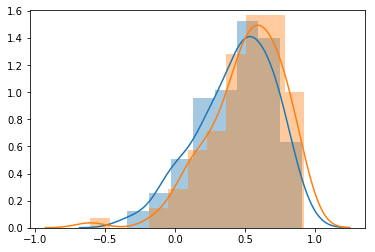

In [595]:
from scipy.stats import pearsonr as corr
my_cL,my_cT = ([],[])
for sub in np.unique(Sib2.subject):
    dat = data=Sib2[(Sib2.subject==sub)&(Sib2.lie==1)]
    my_cL.append(corr(dat.K_.values[0],dat.PG_.values[0])[0])
    dat = data=Sib2[(Sib2.subject==sub)&(Sib2.lie==0)]
    my_cT.append(corr(dat.K_.values[0],dat.PG_.values[0])[0])
sns.distplot(my_cT)
sns.distplot(my_cL)

    

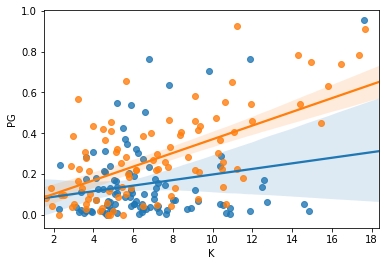

In [598]:
sns.regplot(data=Sib2[Sib2.lie==0],x='K',y='PG')
sns.regplot(data=Sib2[Sib2.lie==1],x='K',y='PG')

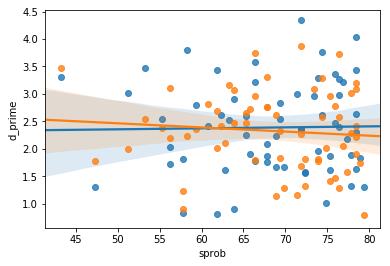

In [656]:
Sib2['sprob'] = (1-Sib2.eprob)*100
var_y = 'd_prime'
sns.regplot(data=Sib2[(Sib2.lie==0)&(Sib.sd_o<30)],x='sprob',y=var_y)
sns.regplot(data=Sib2[(Sib2.lie==1)&(Sib.sd_o<30)],x='sprob',y=var_y)
# sns.regplot(data=Sib2[(Sib2.lie==2)&(Sib.sd_o<30)],x='sprob',y='PG')

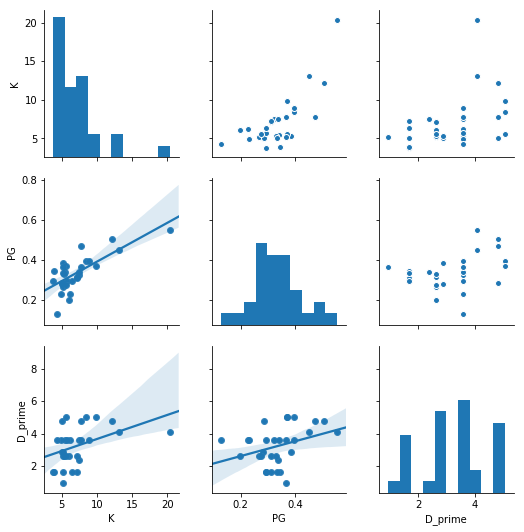

In [622]:
sub = np.unique(Sib2.subject)[3]
dat = data=Sib2[(Sib2.subject==sub)&(Sib2.lie==2)]
K = dat.K_.values[0]
PG = dat.PG_.values[0]
DP = dat.d_prime_.values[0]
T = {'K':K,'PG':PG,'D_prime':DP}
T = pd.DataFrame(data=T)
g = sns.pairplot(T)
g = g.map_lower(sns.regplot)


In [634]:
%%R -i T

mod<- lm(PG~K*D_prime,data=T)
anova(mod)
summary(mod)


Call:
lm(formula = PG ~ K * D_prime, data = T)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.154787 -0.025076  0.001896  0.030773  0.112957 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.430326   0.130724   3.292  0.00287 **
K           -0.022170   0.021892  -1.013  0.32054   
D_prime     -0.058998   0.034249  -1.723  0.09683 . 
K:D_prime    0.010284   0.005397   1.905  0.06783 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05898 on 26 degrees of freedom
Multiple R-squared:  0.5991,	Adjusted R-squared:  0.5529 
F-statistic: 12.95 on 3 and 26 DF,  p-value: 2.289e-05



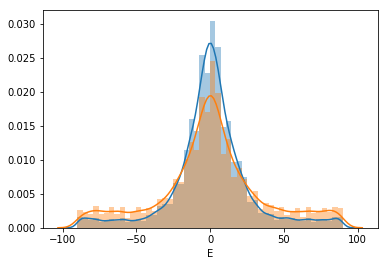

In [630]:
sns.distplot(evF[evF.lie==0].E)
sns.distplot(evF[evF.lie==1].E)

In [637]:
this_E=[]
for i in subjs:
    this_E.append(circ_std(evF[evF.subject==i].E))

In [658]:
from seaborn import catplot

ImportError: cannot import name 'catplot'